In [ ]:
# Model fine-tuned on MLM using combined balanced, tokenized Samogitian and Standard Lithuanain dataset
# - tokenizes data: full bilingual datasets saved as train_ds_mlm, eval_ds_mlm
# - includes model with weighted random sampling
# - includes model with curriculum learning
# - visualization and plots

In [1]:
# Part 0: Load necessary packages
import numpy as np
import torch
import gc
from torch.utils.data import WeightedRandomSampler, DataLoader
from datasets import Dataset, load_from_disk, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments
)
import matplotlib.pyplot as plt

2025-05-12 10:04:26.546035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747058666.791118   14175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747058666.842589   14175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747058667.192600   14175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747058667.192631   14175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747058667.192633   14175 computation_placer.cc:177] computation placer alr

In [4]:
# Prepare data for model

# Load and create test/train for preprocessed datasets
samogitian_dataset = load_from_disk("processed_corpus/samogitian_dataset")
lithuanian_dataset = load_from_disk("processed_corpus/lithuanian_dataset")

# raw splits used by both tokenizers
smg_splits = samogitian_dataset.train_test_split(test_size=0.1, seed=42)
smg_splits = DatasetDict({"train": smg_splits["train"],"test": smg_splits["test"]})
    
lt_splits = lithuanian_dataset.train_test_split(test_size=0.1, seed=42)
lt_splits = DatasetDict({"train": lt_splits["train"],"test": lt_splits["test"]})

# label datasets with language ID (used for classification head and used for mlm to balance dataset)
smg_train = smg_splits["train"].map(lambda ex: {"lang": 0})
lt_train  = lt_splits["train"].map(lambda ex: {"lang": 1})
smg_eval = smg_splits["test"].map(lambda ex: {"lang": 0})
lt_eval   = lt_splits["test"].map(lambda ex: {"lang": 1})

print("Datatsets with train/test split loaded.")

Datatsets with train/test split loaded.


In [2]:
# Load LitLat BERT (pre-trained with SentencePiece Tokenizer)
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/litlat-bert") #loads the tokenizer from Hugging Face
model = AutoModelForMaskedLM.from_pretrained("EMBEDDIA/litlat-bert")  #loads the model to embed Samogitian in MLM
print(f"Successfully loaded model with {model.num_parameters()} parameters")

Some weights of the model checkpoint at EMBEDDIA/litlat-bert were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Successfully loaded model with 150794217 parameters


In [6]:
#Counts tokens for each train/eval split for dataset
def count_tokens(tokenized_dataset):
    total_tokens = 0
    if isinstance(tokenized_dataset, Dataset):
        splits = {"all": tokenized_dataset}
    else:
        splits = tokenized_dataset
    for split_name, split_ds in splits.items(): 
        # excludes padding
        seq_lens = [len(ids) for ids in split_ds["input_ids"]]
        split_tokens = sum(
            sum(1 for token in ids if token != tokenizer.pad_token_id)
            for ids in split_ds["input_ids"]
        )
        num_examples = len(split_ds)
        avg_len = sum(seq_lens) / num_examples if num_examples else 0
        label = split_name.capitalize() if split_name else "Dataset"
        total_tokens += split_tokens

    return total_tokens

In [9]:
# Tokenize dataset for MLM

remove_columns=["text", "source", "id"] 
columns=['input_ids', 'attention_mask', 'special_tokens_mask']
max_length = 512 #longer context needed
SEED = 42
gc.collect()
torch.cuda.empty_cache()

def tokenize_mlm(dataset, tokenizer):    
    def tokenize_function(page):
        return tokenizer(
            page["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_special_tokens_mask=True,
        )
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        batch_size=64,
        num_proc=4,
        remove_columns=remove_columns,
        desc="Tokenizing dataset"
    ).with_format("torch", columns=columns)
    return tokenized_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# More memory efficient to process each split distinctly
smg_train_mlm = tokenize_mlm(smg_train, tokenizer)
lt_train_mlm = tokenize_mlm(lt_train, tokenizer)
smg_eval_mlm = tokenize_mlm(smg_eval, tokenizer)
lt_eval_mlm = tokenize_mlm(lt_eval, tokenizer)

# Print token count
smg_tokens_train = count_tokens(smg_train_mlm)
print(f"Total training Samogitian tokens: {smg_tokens_train:,}")
smg_tokens_eval = count_tokens(smg_eval_mlm)
print(f"Total eval Samogitian tokens: {smg_tokens_eval:,}")

lt_tokens_train = count_tokens(lt_train_mlm)
print(f"Total training Lithuanian tokens: {lt_tokens_train:,}")
lt_tokens_eval = count_tokens(lt_eval_mlm)
print(f"Total eval Lithuanian tokens: {lt_tokens_eval:,}")

ratio = lt_tokens_train/smg_tokens_train
print(f"Ratio of Lithuanian training tokens to Samogitian training tokens: {ratio,}")

# Uncomment for alternative to WeightedRandomSample: Downsample Lithuanian
#if ratio > 1:
    #print("Perioridic downsampling of Lithuanian dataset:")
    #lt_train = lt_train.shuffle(seed=SEED).select(range(len(smg_train)))

smg_train_mlm.save_to_disk("tokenized_smg_train_mlm")
lt_train_mlm.save_to_disk("tokenized_lt_train_mlm")
smg_eval_mlm.save_to_disk("tokenized_smg_eval_mlm")
lt_eval_mlm.save_to_disk("tokenized_lt_eval_mlm")
train_ds_mlm = concatenate_datasets([smg_train_mlm, lt_train_mlm]).shuffle(seed=SEED)
eval_ds_mlm  = concatenate_datasets([smg_eval_mlm, lt_eval_mlm]).shuffle(seed=SEED)
train_ds_mlm.save_to_disk("train_ds_mlm")
eval_ds_mlm.save_to_disk("eval_ds_mlm")

Total training Samogitian tokens: 894,946
Total eval Samogitian tokens: 100,499
Total training Lithuanian tokens: 60,183,196
Total eval Lithuanian tokens: 60,183,196
Ratio of Lithuanian training tokens to Samogitian training tokens: (67.24785182569674,)


Saving the dataset (0/1 shards):   0%|          | 0/4433 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/208642 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/493 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/208642 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/213075 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/209135 [00:00<?, ? examples/s]

In [ ]:
# Fine tune with MLM (with weighted sampling, without curriculum learning)
# TO DO: adjust p_smg to achieve desired ratio of Samogitian-Lithuanian weighting

train_ds_mlm = load_from_disk("train_ds_mlm")
eval_ds_mlm = load_from_disk("eval_ds_mlm")

class MLMTrainer:
    def __init__(self, model, train_ds, eval_ds, tokenizer, output_dir="./mlm_model_sampling",
                 batch_size=8, learning_rate=5e-5, epochs=3, num_workers=4, 
                 gradient_accumulation_steps=4, p_smg=0.8):
        self.model = model
        self.train_ds = train_ds
        self.eval_ds = eval_ds
        self.tokenizer = tokenizer
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_workers = num_workers
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.p_smg = p_smg 
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Training metrics nad statistics
        self.best_eval_loss = float('inf')
        self.train_losses = []
        self.eval_losses = []
        self.learning_rates = []
        self.perplexities = []
        
        # Data loaders with weighted sampling to create balanced dataset
        self.train_dataloader, self.eval_dataloader = self._setup_data_loaders()
    
    def _setup_data_loaders(self):
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=True,
            mlm_probability=0.15 
        )
        sampler = self._balanced_sampler()
        
        train_dataloader = DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            sampler=sampler,
            collate_fn=data_collator,
            num_workers=self.num_workers,
            pin_memory=True
        )

        eval_dataloader = DataLoader(
            self.eval_ds,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=data_collator,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        return train_dataloader, eval_dataloader
    
    def _balanced_sampler(self):
        #Count number of samples in each language class
        langs = self.train_ds["lang"]
        num_smg = sum(1 for l in langs if l == 0)
        num_lt = sum(1 for l in langs if l == 1)
        
        # weight tensor contains a weight for each sample in class
        w_smg = self.p_smg/num_smg
        w_lt = (1-self.p_smg)/num_lt
        weights = [w_smg if l == 0 else w_lt for l in langs]
        return WeightedRandomSampler(
            weights=weights,
            num_samples=len(weights),
            replacement=True
        )
    
    def fine_tune(self):
        torch.cuda.empty_cache()
        gc.collect()
        self.model = self.model.to(self.device)
        
        scaler = torch.cuda.amp.GradScaler()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=0.01)
        
        # learning rate scheduler
        total_steps = ((len(self.train_dataloader) + self.gradient_accumulation_steps - 1) 
                      // self.gradient_accumulation_steps) * self.epochs
        warmup_steps = int(total_steps * 0.1)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.learning_rate,
            total_steps=total_steps,
            pct_start=warmup_steps/total_steps
        )
        
        #training phase 
        print(f"Starting to train with balanced set")
        steps = 0
        
        for epoch in range(self.epochs):
            self.model.train()
            total_train_loss = 0
            optimizer.zero_grad()  
            
            for batch_idx, batch in enumerate(self.train_dataloader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                with torch.cuda.amp.autocast():
                    outputs = self.model(**batch)
                    loss = outputs.loss / self.gradient_accumulation_steps
                
                scaler.scale(loss).backward()
                current_lr = scheduler.get_last_lr()[0]
                self.learning_rates.append(current_lr)  #adds to metrics

                
                if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
                    steps += 1
                
                total_train_loss += loss.item() * self.gradient_accumulation_steps
                
                if batch_idx % 200 == 0:
                    print(f"Epoch {epoch+1}/{self.epochs}, Batch {batch_idx}/{len(self.train_dataloader)}, "
                          f"Loss: {loss.item() * self.gradient_accumulation_steps:.4f}, LR: {current_lr:.6f}")
            
            # remaining batches not divisible by gradient_accumulation_steps
            if len(self.train_dataloader) % self.gradient_accumulation_steps != 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            avg_train_loss = total_train_loss / len(self.train_dataloader)
            self.train_losses.append(avg_train_loss)
            print(f"Epoch {epoch+1}/{self.epochs} completed. Average training loss: {avg_train_loss:.4f}")

            # Evaluation
            torch.cuda.empty_cache()
            gc.collect()
            self.model.eval()
            total_eval_loss = 0
            with torch.no_grad():
                for batch in self.eval_dataloader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    with torch.cuda.amp.autocast():
                        outputs = self.model(**batch)
                    total_eval_loss += outputs.loss.item()
            
            avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
            self.eval_losses.append(avg_eval_loss)
            
            perplexity = torch.exp(torch.tensor(avg_eval_loss)).item()
            self.perplexities.append(perplexity)
            
            print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                  f"Eval Loss: {avg_eval_loss:.4f}, Perplexity: {perplexity:.2f}")
     
            # Save improved models
            if avg_eval_loss < self.best_eval_loss:
                self.best_eval_loss = avg_eval_loss
                self.model.save_pretrained(self.output_dir)
                self.tokenizer.save_pretrained(self.output_dir)
                metrics = self._get_metrics()
                metrics['epochs'] = list(range(1, epoch+2))
                torch.save(metrics, f"{self.output_dir}/training_metrics.pt")
        
        print(f"done. best eval loss: {self.best_eval_loss:.4f}")
        return self.model, self._get_metrics()
    
    def _get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'eval_losses': self.eval_losses,
            'learning_rates': self.learning_rates,
            'perplexities': self.perplexities,
            'best_eval_loss': self.best_eval_loss
        }


trainer = MLMTrainer(
    model=model,
    train_ds=train_ds_mlm,
    eval_ds=eval_ds_mlm,
    tokenizer=tokenizer,
    output_dir="./mlm_model_sampling,
    batch_size=8,
    learning_rate=5e-5,
    epochs=3,
    num_workers=4,
    gradient_accumulation_steps=4,
    p_smg=0.8
)

model, metrics = trainer.fine_tune()

In [8]:
# # Fine tune on MLM (with curriculum learning)
train_ds_mlm = load_from_disk("train_ds_mlm")
eval_ds_mlm = load_from_disk("eval_ds_mlm")

class MLMTrainer:
    def __init__(self, model, train_ds, eval_ds, tokenizer, output_dir="./mlm_fine_tuned_model2",
                 batch_size=16, learning_rate=5e-5, epochs=3, num_workers=6, 
                 gradient_accumulation_steps=4, p_smg=0.8):
        self.model = model
        self.train_ds = train_ds
        self.eval_ds = eval_ds
        self.tokenizer = tokenizer
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_workers = num_workers
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.p_smg = p_smg
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #  metrics nad statistics
        self.best_eval_loss = float('inf')
        self.train_losses = []
        self.eval_losses = []
        self.learning_rates = []
        self.perplexities = []
        
    # Prepare data loaders with baalnced sampler
        self.train_dataloader, self.eval_dataloader = self._setup_data_loaders()
    
    def _setup_data_loaders(self):
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=True,
            mlm_probability=0.15
        )
        sampler = self._balanced_sampler()
        
        train_dataloader = DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            sampler=sampler,
            collate_fn=data_collator,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        eval_dataloader = DataLoader(
            self.eval_ds,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=data_collator,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        return train_dataloader, eval_dataloader
    
    def _balanced_sampler(self):
        langs = self.train_ds["lang"]
        # Count number of samples in each language class
        num_smg = sum(1 for l in langs if l == 0)
        num_lt = sum(1 for l in langs if l == 1)
        
        # weight tensor contains a weight for each sample in class
        w_smg = self.p_smg/num_smg
        w_lt = (1-self.p_smg)/num_lt
        weights = [w_smg if l == 0 else w_lt for l in langs]
        return WeightedRandomSampler(
            weights=weights,
            num_samples=len(weights),
            replacement=True
        )
    
    def _freeze_layers(self, num_layers_to_unfreeze=None):
        # First freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # unfreeze embeddings and final layer
        for param in self.model.roberta.embeddings.parameters():
            param.requires_grad = True
        for param in self.model.lm_head.parameters():
            param.requires_grad = True
        
        # Depending on the phase, unfreeze k top layers
        if num_layers_to_unfreeze is not None:
            if num_layers_to_unfreeze > 0:
                total_layers = len(self.model.roberta.encoder.layer)
                for i in range(total_layers - num_layers_to_unfreeze, total_layers):
                    for param in self.model.roberta.encoder.layer[i].parameters():
                        param.requires_grad = True
        
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.2%})")
    
    def fine_tune(self):
        torch.cuda.empty_cache()
        gc.collect()
        self.model = self.model.to(self.device)
        
        scaler = torch.cuda.amp.GradScaler()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=0.01)
        
        # learning rate scheduler
        total_steps = ((len(self.train_dataloader) + self.gradient_accumulation_steps - 1) 
                      // self.gradient_accumulation_steps) * self.epochs
        warmup_steps = int(total_steps * 0.1)  # 10% warmup
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.learning_rate,
            total_steps=total_steps,
            pct_start=warmup_steps/total_steps
        )
        
        # training phase
        steps = 0
        print(f"Starting to train using curriculum learning")
        
        # phases progressively unfreeze layers, introduce more Standard Lithuanian
        curriculum = [
            {"epoch": 0, "p_smg": 0.8, "unfreeze_layers": 0},
            {"epoch": 1, "p_smg": 0.6, "unfreeze_layers": 6},
            {"epoch": 2, "p_smg": 0.5, "unfreeze_layers": 12},
        ]
        
        for epoch in range(self.epochs):
            for phase in curriculum:
                if phase["epoch"] == epoch:
                    self.p_smg = phase["p_smg"] #Update proportion of Samogitian
                    self._freeze_layers(phase["unfreeze_layers"]) #unfreeze layers
                    # Recreate dataloader with new sampling weights
                    self.train_dataloader, _ = self._setup_data_loaders()
                    # Reset optimizer to update for newly unfrozen parameters
                    optimizer = torch.optim.AdamW(
                        [p for p in self.model.parameters() if p.requires_grad], 
                        lr=self.learning_rate, 
                        weight_decay=0.01
                    )
                    print(f"Curriculum Phase {epoch+1}: Samogitian ratio: {self.p_smg:.1f}, "
                          f"Unfrozen layers: {phase['unfreeze_layers']}")
                    break
            
            self.model.train()
            total_train_loss = 0
            optimizer.zero_grad()  
            
            for batch_idx, batch in enumerate(self.train_dataloader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                with torch.cuda.amp.autocast():
                    outputs = self.model(**batch)
                    loss = outputs.loss / self.gradient_accumulation_steps
                
                scaler.scale(loss).backward()
                current_lr = scheduler.get_last_lr()[0]
                self.learning_rates.append(current_lr) 

                
                if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
                    steps += 1
                
                total_train_loss += loss.item() * self.gradient_accumulation_steps
                
                if batch_idx % 200 == 0:
                    print(f"Epoch {epoch+1}/{self.epochs}, Batch {batch_idx}/{len(self.train_dataloader)}, "
                          f"Loss: {loss.item() * self.gradient_accumulation_steps:.4f}, LR: {current_lr:.6f}")
            
            if len(self.train_dataloader) % self.gradient_accumulation_steps != 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            avg_train_loss = total_train_loss / len(self.train_dataloader)
            self.train_losses.append(avg_train_loss)
            print(f"Epoch {epoch+1}/{self.epochs} completed. Average training loss: {avg_train_loss:.4f}")

            # Evaluation 
            torch.cuda.empty_cache()
            gc.collect()
            self.model.eval()
            total_eval_loss = 0
            with torch.no_grad():
                for batch in self.eval_dataloader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    with torch.cuda.amp.autocast():
                        outputs = self.model(**batch)
                    total_eval_loss += outputs.loss.item()
            
            avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
            self.eval_losses.append(avg_eval_loss)
            
            perplexity = torch.exp(torch.tensor(avg_eval_loss)).item()
            self.perplexities.append(perplexity)
            print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                  f"Eval Loss: {avg_eval_loss:.4f}, Perplexity: {perplexity:.2f}")
     
            # Save improved models
            if avg_eval_loss < self.best_eval_loss:
                self.best_eval_loss = avg_eval_loss
                self.model.save_pretrained(self.output_dir)
                self.tokenizer.save_pretrained(self.output_dir)
                metrics = self._get_metrics()
                metrics['epochs'] = list(range(1, epoch+2))
                torch.save(metrics, f"{self.output_dir}/training_metrics.pt")
            
            # Early stop if no improvment after 2 epochs
            if epoch >= 2 and len(self.eval_losses) >= 3 and self.eval_losses[-1] > self.eval_losses[-2] > self.eval_losses[-3]:
                print(f"Early stop triggered: No improvement for 2 epochs")
                break
        
        print(f"Fine-tuning completed. Best evaluation loss: {self.best_eval_loss:.4f}")
        return self.model, self._get_metrics()
    
    def _get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'eval_losses': self.eval_losses,
            'learning_rates': self.learning_rates,
            'perplexities': self.perplexities,
            'best_eval_loss': self.best_eval_loss
        }

In [9]:
trainer = MLMTrainer(
    model=model,
    train_ds=train_ds_mlm,
    eval_ds=eval_ds_mlm,
    tokenizer=tokenizer,
    output_dir="./samogitian_litlat_bert2",
    batch_size=16,
    learning_rate=5e-5,
    epochs=3,
    num_workers=6,
    gradient_accumulation_steps=4,
    p_smg=0.8  
)

model, metrics = trainer.fine_tune()

Starting fine-tuning on device: cuda
Using 6 CPU workers for data loading
Trainable parameters: 65,739,753 / 150,794,217 (43.60%)
Curriculum Phase 1: Samogitian ratio: 0.8, Unfrozen layers: 0
Epoch 1/3, Batch 0/13318, Loss: 5.1351, LR: 0.000002
Epoch 1/3, Batch 200/13318, Loss: 4.7045, LR: 0.000002
Epoch 1/3, Batch 400/13318, Loss: 4.1734, LR: 0.000003
Epoch 1/3, Batch 600/13318, Loss: 4.4309, LR: 0.000005
Epoch 1/3, Batch 800/13318, Loss: 4.3921, LR: 0.000007
Epoch 1/3, Batch 1000/13318, Loss: 3.5779, LR: 0.000009
Epoch 1/3, Batch 1200/13318, Loss: 4.1897, LR: 0.000012
Epoch 1/3, Batch 1400/13318, Loss: 4.5230, LR: 0.000015
Epoch 1/3, Batch 1600/13318, Loss: 3.6515, LR: 0.000019
Epoch 1/3, Batch 1800/13318, Loss: 3.8274, LR: 0.000022
Epoch 1/3, Batch 2000/13318, Loss: 3.6414, LR: 0.000026
Epoch 1/3, Batch 2200/13318, Loss: 3.6374, LR: 0.000030
Epoch 1/3, Batch 2400/13318, Loss: 3.5758, LR: 0.000034
Epoch 1/3, Batch 2600/13318, Loss: 3.9745, LR: 0.000037
Epoch 1/3, Batch 2800/13318, Lo

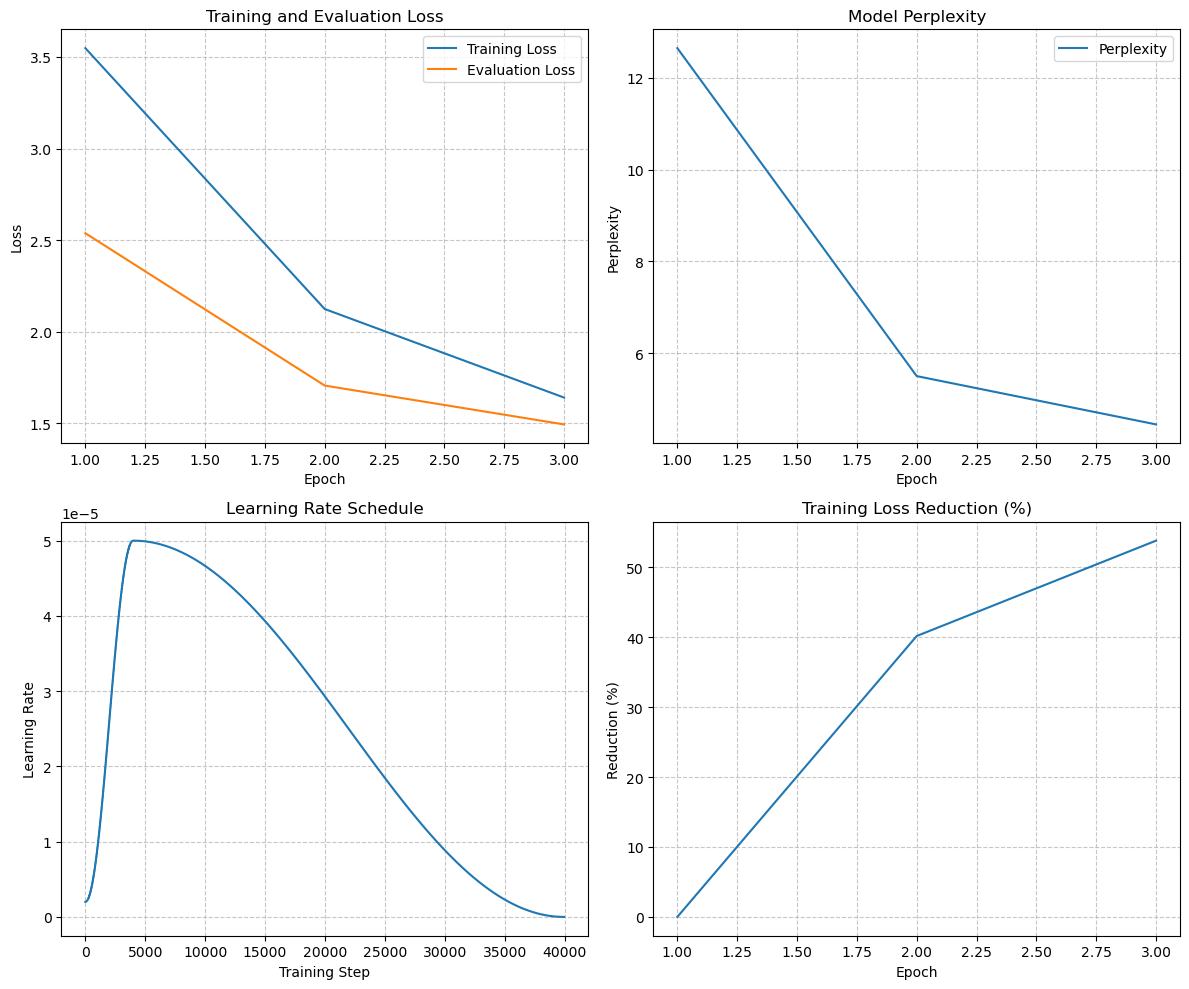

In [13]:
# Visualize results (plots created using ChatGPT)

num_epochs = len(metrics['train_losses'])
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 10))

# 1) Training & Eval Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics['train_losses'],  label='Training Loss')
plt.plot(epochs, metrics['eval_losses'],   label='Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 2) Perplexity
plt.subplot(2, 2, 2)
plt.plot(epochs, metrics['perplexities'], label='Perplexity')
plt.title('Model Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 3) Learning Rate Schedule
steps = list(range(1, len(metrics['learning_rates']) + 1))
plt.subplot(2, 2, 3)
plt.plot(steps, metrics['learning_rates'])
plt.title('Learning Rate Schedule')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.grid(True, linestyle='--', alpha=0.7)

# 4) Loss Reduction Percentage
if num_epochs > 1:
    initial = metrics['train_losses'][0]
    loss_reduction = [(initial - l) / initial * 100 for l in metrics['train_losses']]
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss_reduction)
    plt.title('Training Loss Reduction (%)')
    plt.xlabel('Epoch')
    plt.ylabel('Reduction (%)')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./samogitian_litlat_bert2/training_metrics.png", dpi=300)
plt.show()
